In [1]:
#JesseRuiz_Capstoneproject_PredictingRecidivisminDomesticViolence_Phase2

# PLAN - PHASE 2

0. [x] Get the data.
0. [x] Prepare the data for exploration.
0. [x] Split the data into train and test sets.
0. [x] Explore the data.
0. [x] Do cross-validation with the data.
0. [x] Code and evaluate several models.
0. [ ] Evaluate out of sample data (test set).

# ENVIRONMENT

In [2]:
# basic environment and custom scripts
import os
import acquire
import prepare
import explore
import time

# from prepare import rename_columns
# from prepare import replace_nonvals
# from prepare import value_counts

# numpy and pandas for dataframe building and manipulation
import pandas as pd
import numpy as np
%matplotlib inline

# matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import preprocessing for scaling and splitting
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# xgboost for feature selection
import xgboost as xgb

# for tsne plot
from sklearn.manifold import TSNE

# for PCA
from sklearn.decomposition import PCA


# Grid search
from sklearn.model_selection import GridSearchCV

# sklearn machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score

#  balanced bagging classifier
from imblearn.ensemble import BalancedBaggingClassifier

from functools import reduce

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# PHASE 2 INFORMATION

## During phase 2, we look at a subset of our dataframe (705 cases/respondents) and examine the 497 AW (Abused Woman) cases where there was multiple cases of assault (re-assault).
* The target variable changes from Abuse_past_year to Reassault.
* The focus shifts to analyzing the features that predict that there will be reassault, instead of analyzing when there will be abuse or not.

# ACQUISITION

## Dataframes 6 & 11 contain information on AW (Abused Woman) cases.

In [4]:
dfa, dfb = acquire.get_data()

In [5]:
# dfa is datasets 1, 2, 3, 4, 5, 7. All cases AW and NAW.
dfa.head()

,CASEID,ABUSED,SCRSTATR,LENGTHC1,C1SITUAT,PABUSE,D3RCHILT,E13PRGNT,N7PREGNT,TOTSUPRT,...,N16CHILD,N17ARRST,N1FRQNCY,N2SVRITY,N3WEAPON,N4CHOKE,N5SEX,N6CONTRL,N8JEALUS,N10CPBLE
0,108395,1,1,1,1,1,1,3,2,9,...,2,2,2,2,2,2,2,2,2,2
1,108397,1,1,2,1,1,0,3,3,11,...,2,1,2,1,1,1,1,2,1,1
2,108399,1,1,5,1,1,6,3,2,9,...,2,2,2,2,2,1,2,2,2,2
3,108443,1,1,2,1,1,0,1,2,12,...,2,1,2,2,1,1,2,1,2,2
4,108444,1,1,2,1,1,1,2,2,11,...,2,1,1,1,2,2,2,2,2,2


In [6]:
# dfb is datasets 6 & 11. AW cases only.
dfb.head()

,CASEID,M5FIRED,M11HIGH,M35SAFE,M41ILLGL,M42DAGRR,M13TALKR,M32OTHER,M27HOW,M30ARRES,...,FORCEDR,MISCARR,RESTRAIN,CHOKED,NDRUNK,RDRUNK,BOTHDRUN,NDRUGS,RDRUGS,BOTHDRUG
0,108395,9999,2,1,2,0,1,99,99999,3,...,0,0,0,0,0,0,0,0,0,0
1,108397,9999,2,1,2,0,1,99,99999,3,...,0,0,0,1,2,0,0,0,0,0
2,108399,9999,2,1,2,0,1,99,99999,3,...,0,0,1,1,0,0,0,0,0,0
3,108443,9999,2,1,2,0,1,13,99999,3,...,0,0,0,1,1,0,0,0,0,0
4,108444,9999,1,1,2,0,1,99,99999,3,...,0,0,0,0,3,0,0,0,0,0


# Examine dfb in more detail. Use custom functions from prepare script to take information from df10 and create a column that shows which cases had repeat offenses.

In [7]:
dfb['RECID'] = dfb.CASEID.apply(prepare.get_repeat_case)

In [8]:
dfb.head()

,CASEID,M5FIRED,M11HIGH,M35SAFE,M41ILLGL,M42DAGRR,M13TALKR,M32OTHER,M27HOW,M30ARRES,...,MISCARR,RESTRAIN,CHOKED,NDRUNK,RDRUNK,BOTHDRUN,NDRUGS,RDRUGS,BOTHDRUG,RECID
0,108395,9999,2,1,2,0,1,99,99999,3,...,0,0,0,0,0,0,0,0,0,0
1,108397,9999,2,1,2,0,1,99,99999,3,...,0,0,1,2,0,0,0,0,0,1
2,108399,9999,2,1,2,0,1,99,99999,3,...,0,1,1,0,0,0,0,0,0,1
3,108443,9999,2,1,2,0,1,13,99999,3,...,0,0,1,1,0,0,0,0,0,0
4,108444,9999,1,1,2,0,1,99,99999,3,...,0,0,0,3,0,0,0,0,0,1


# Clean up the dataset for exploration...

In [9]:
dfb.columns

Index(['CASEID', 'M5FIRED', 'M11HIGH', 'M35SAFE', 'M41ILLGL', 'M42DAGRR',
       'M13TALKR', 'M32OTHER', 'M27HOW', 'M30ARRES', 'M31HOW', 'M38ORDER',
       'SEVERER', 'TOTINCR', 'THREATR', 'SLAPR', 'PUNCHR', 'BEATR', 'UWEAPON',
       'FORCEDR', 'MISCARR', 'RESTRAIN', 'CHOKED', 'NDRUNK', 'RDRUNK',
       'BOTHDRUN', 'NDRUGS', 'RDRUGS', 'BOTHDRUG', 'RECID'],
      dtype='object')

In [10]:
dfb = prepare.rename_columns_recid(dfb)

In [11]:
dfb.head()

,id,gun_fired,anyone_high,safe_place,forced_illegal,life_danger,talk_about_it,left_or_not,medical_staff_helpful,perp_arrested_ever,...,miscarriage_resulted,restrained_by_perp,num_choked,num_perp_drunk,num_woman_drunk,num_both_drunk,num_perp_drugs,num_woman_drugs,num_both_drugs,reassault
0,108395,9999,2,1,2,0,1,99,99999,3,...,0,0,0,0,0,0,0,0,0,0
1,108397,9999,2,1,2,0,1,99,99999,3,...,0,0,1,2,0,0,0,0,0,1
2,108399,9999,2,1,2,0,1,99,99999,3,...,0,1,1,0,0,0,0,0,0,1
3,108443,9999,2,1,2,0,1,13,99999,3,...,0,0,1,1,0,0,0,0,0,0
4,108444,9999,1,1,2,0,1,99,99999,3,...,0,0,0,3,0,0,0,0,0,1


In [12]:
prepare.value_counts(dfb)

# for col in dfb.columns:
# #         n = dfb[col].unique().shape[0]
# #         col_bins = min(n, 10)
#         print(f'{col}:')
#         if dfb[col].dtype in ['int64', 'float64']:
#             print(dfb[col].value_counts(sort=False, dropna=False))
#         else:
#             print(dfb[col].value_counts(dropna=False))
#         print('\n')

id

-------------------------------------------------------------

gun_fired
1        10
2        41
9999    444
999       2
Name: gun_fired, dtype: int64

-------------------------------------------------------------

anyone_high
1      101
2      389
888      2
999      5
Name: anyone_high, dtype: int64

-------------------------------------------------------------

safe_place
1      391
2       97
999      9
Name: safe_place, dtype: int64

-------------------------------------------------------------

forced_illegal
1       86
2      402
999      9
Name: forced_illegal, dtype: int64

-------------------------------------------------------------

life_danger
0      240
1      249
999      8
Name: life_danger, dtype: int64

-------------------------------------------------------------

talk_about_it
1      352
2      140
999      5
Name: talk_about_it, dtype: int64

-------------------------------------------------------------

left_or_not
(10.911000000000001, 19.8]    125
(19.8, 28.6

In [13]:
prepare.replace_nonvals_recid(dfb)

In [14]:
dfb.head()

,id,gun_fired,anyone_high,safe_place,forced_illegal,life_danger,talk_about_it,left_or_not,medical_staff_helpful,perp_arrested_ever,...,miscarriage_resulted,restrained_by_perp,num_choked,num_perp_drunk,num_woman_drunk,num_both_drunk,num_perp_drugs,num_woman_drugs,num_both_drugs,reassault
0,108395,0,0,1,0,0,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1,108397,0,0,1,0,0,1,0,0,3,...,0,0,1,2,0,0,0,0,0,1
2,108399,0,0,1,0,0,1,0,0,3,...,0,1,1,0,0,0,0,0,0,1
3,108443,0,0,1,0,0,1,1,0,3,...,0,0,1,1,0,0,0,0,0,0
4,108444,0,1,1,0,0,1,0,0,3,...,0,0,0,3,0,0,0,0,0,1


In [15]:
# Check the value counts of the columns to make sure the function worked
prepare.value_counts(dfb)

id

-------------------------------------------------------------

gun_fired
0    487
1     10
Name: gun_fired, dtype: int64

-------------------------------------------------------------

anyone_high
0    396
1    101
Name: anyone_high, dtype: int64

-------------------------------------------------------------

safe_place
0    106
1    391
Name: safe_place, dtype: int64

-------------------------------------------------------------

forced_illegal
0    411
1     86
Name: forced_illegal, dtype: int64

-------------------------------------------------------------

life_danger
0    248
1    249
Name: life_danger, dtype: int64

-------------------------------------------------------------

talk_about_it
0    145
1    352
Name: talk_about_it, dtype: int64

-------------------------------------------------------------

left_or_not
0    372
1    125
Name: left_or_not, dtype: int64

-------------------------------------------------------------

medical_staff_helpful
0     451
11      7
21   

# Prepare dfa to merge it with the dfb

In [16]:
dfa.columns

Index(['CASEID', 'ABUSED', 'SCRSTATR', 'LENGTHC1', 'C1SITUAT', 'PABUSE',
       'D3RCHILT', 'E13PRGNT', 'N7PREGNT', 'TOTSUPRT', 'G1NUMBER', 'H1JEALUS',
       'H2LIMIT', 'H3KNOWNG', 'J1HIT', 'J2THROWN', 'J3PUSH', 'J4SLAP',
       'J5KICK', 'J6OBJECT', 'J7BEAT', 'J8CHOKE', 'J9KNIFE', 'J10GUN',
       'J11SEX', 'POWER', 'HARASS', 'B1AGE', 'AGEDISP', 'STDETAI', 'SAMESEXR',
       'N11DRUGS', 'N12ALCHL', 'N13SUHIM', 'N16CHILD', 'N17ARRST', 'N1FRQNCY',
       'N2SVRITY', 'N3WEAPON', 'N4CHOKE', 'N5SEX', 'N6CONTRL', 'N8JEALUS',
       'N10CPBLE'],
      dtype='object')

In [17]:
#use prepare function to rename features 
dfa = prepare.rename_columns_all(dfa)

In [18]:
# use prepare function to re-encode data
prepare.replace_nonvals_all(dfa)

In [19]:
dfa.head()

,id,abuse_past_year,abuse_status,length_relationship,partner_abusive,num_abusers,num_children,pregnant,beaten_while_pregnant,support_score,...,partner_reported_child_abuse,partner_arrested,violence_increased,severity_increased,weapon_ever,choked_ever,rape_ever,controlled_ever,jealous,capable_murder
0,108395,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108397,1,1,2,1,1,0,0,0,11,...,0,1,0,1,1,1,1,0,1,1
2,108399,1,1,5,1,1,2,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,108443,1,1,2,1,1,0,1,0,12,...,0,1,0,0,1,1,0,1,0,0
4,108444,1,1,2,1,1,1,0,0,11,...,0,1,1,1,0,0,0,0,0,0


In [20]:
dfa.columns

Index(['id', 'abuse_past_year', 'abuse_status', 'length_relationship',
       'partner_abusive', 'num_abusers', 'num_children', 'pregnant',
       'beaten_while_pregnant', 'support_score', 'guns_in_home',
       'jealous_past_year', 'limit_family_contact', 'location_tracking',
       'threat_hit', 'threat_object', 'push_shove', 'slap', 'kick_punch',
       'hit_object', 'beaten', 'choked', 'threat_knife', 'threat_gun',
       'rape_with_threat', 'power_scale', 'harass_scale', 'id_age',
       'age_disparity', 'children_not_partner', 'same_sex_relationship',
       'partner_drug_use', 'partner_alcohol_use', 'threat_suicide',
       'partner_reported_child_abuse', 'partner_arrested',
       'violence_increased', 'severity_increased', 'weapon_ever',
       'choked_ever', 'rape_ever', 'controlled_ever', 'jealous',
       'capable_murder'],
      dtype='object')

In [21]:
prepare.merge_all_recid(dfa, dfb)

,id,abuse_past_year,abuse_status,length_relationship,partner_abusive,num_abusers,num_children,pregnant,beaten_while_pregnant,support_score,...,miscarriage_resulted,restrained_by_perp,num_choked,num_perp_drunk,num_woman_drunk,num_both_drunk,num_perp_drugs,num_woman_drugs,num_both_drugs,reassault
0,108395,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108397,1,1,2,1,1,0,0,0,11,...,0,0,1,2,0,0,0,0,0,1
2,108399,1,1,5,1,1,2,0,0,0,...,0,1,1,0,0,0,0,0,0,1
3,108443,1,1,2,1,1,0,1,0,12,...,0,0,1,1,0,0,0,0,0,0
4,108444,1,1,2,1,1,1,0,0,11,...,0,0,0,3,0,0,0,0,0,1
5,108456,1,1,2,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,108460,1,1,3,1,1,1,0,1,10,...,0,0,0,0,0,0,0,0,0,1
7,108525,1,1,4,1,2,2,0,0,11,...,0,0,0,0,0,0,0,0,0,1
8,108562,1,1,5,1,1,2,0,0,11,...,0,0,0,2,0,0,0,0,0,1
9,118051,1,0,6,1,1,2,0,0,10,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df = prepare.merge_all_recid(dfa, dfb)

In [23]:
df.head()

,id,abuse_past_year,abuse_status,length_relationship,partner_abusive,num_abusers,num_children,pregnant,beaten_while_pregnant,support_score,...,miscarriage_resulted,restrained_by_perp,num_choked,num_perp_drunk,num_woman_drunk,num_both_drunk,num_perp_drugs,num_woman_drugs,num_both_drugs,reassault
0,108395,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108397,1,1,2,1,1,0,0,0,11,...,0,0,1,2,0,0,0,0,0,1
2,108399,1,1,5,1,1,2,0,0,0,...,0,1,1,0,0,0,0,0,0,1
3,108443,1,1,2,1,1,0,1,0,12,...,0,0,1,1,0,0,0,0,0,0
4,108444,1,1,2,1,1,1,0,0,11,...,0,0,0,3,0,0,0,0,0,1


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497 entries, 0 to 496
Data columns (total 73 columns):
id                              497 non-null int64
abuse_past_year                 497 non-null int64
abuse_status                    497 non-null int64
length_relationship             497 non-null int64
partner_abusive                 497 non-null int64
num_abusers                     497 non-null int64
num_children                    497 non-null int64
pregnant                        497 non-null int64
beaten_while_pregnant           497 non-null int64
support_score                   497 non-null int64
guns_in_home                    497 non-null int64
jealous_past_year               497 non-null int64
limit_family_contact            497 non-null int64
location_tracking               497 non-null int64
threat_hit                      497 non-null int64
threat_object                   497 non-null int64
push_shove                      497 non-null int64
slap                        

# Check for nulls

In [25]:
# Check for nulls
prepare.get_nulls_by_column(dfb)

Empty DataFrame
Columns: [sum_nulls, nulls_by_percent]
Index: []


In [26]:
prepare.get_nulls_by_row(dfb)

# No nulls found

In [27]:
prepare.get_nulls_by_column(df)

Empty DataFrame
Columns: [sum_nulls, nulls_by_percent]
Index: []


In [28]:
prepare.get_nulls_by_row(df)

# No nulls found

In [29]:
df.columns

Index(['id', 'abuse_past_year', 'abuse_status', 'length_relationship',
       'partner_abusive', 'num_abusers', 'num_children', 'pregnant',
       'beaten_while_pregnant', 'support_score', 'guns_in_home',
       'jealous_past_year', 'limit_family_contact', 'location_tracking',
       'threat_hit', 'threat_object', 'push_shove', 'slap', 'kick_punch',
       'hit_object', 'beaten', 'choked', 'threat_knife', 'threat_gun',
       'rape_with_threat', 'power_scale', 'harass_scale', 'id_age',
       'age_disparity', 'children_not_partner', 'same_sex_relationship',
       'partner_drug_use', 'partner_alcohol_use', 'threat_suicide',
       'partner_reported_child_abuse', 'partner_arrested',
       'violence_increased', 'severity_increased', 'weapon_ever',
       'choked_ever', 'rape_ever', 'controlled_ever', 'jealous',
       'capable_murder', 'gun_fired', 'anyone_high', 'safe_place',
       'forced_illegal', 'life_danger', 'talk_about_it', 'left_or_not',
       'medical_staff_helpful', 'perp_a

In [30]:
len(list(df.columns))

73

# This is a quick check to see if EXPLORATION changes significantly between non padded data and padded data!

In [31]:
# create list of features
features1 = [col for col in df]
# drop features from this list that are perceived as primary key or target variable
features1.remove('id')
features1.remove('abuse_past_year')
features1.remove('abuse_status')
features1.remove('reassault')

In [32]:
df.head()

,id,abuse_past_year,abuse_status,length_relationship,partner_abusive,num_abusers,num_children,pregnant,beaten_while_pregnant,support_score,...,miscarriage_resulted,restrained_by_perp,num_choked,num_perp_drunk,num_woman_drunk,num_both_drunk,num_perp_drugs,num_woman_drugs,num_both_drugs,reassault
0,108395,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108397,1,1,2,1,1,0,0,0,11,...,0,0,1,2,0,0,0,0,0,1
2,108399,1,1,5,1,1,2,0,0,0,...,0,1,1,0,0,0,0,0,0,1
3,108443,1,1,2,1,1,0,1,0,12,...,0,0,1,1,0,0,0,0,0,0
4,108444,1,1,2,1,1,1,0,0,11,...,0,0,0,3,0,0,0,0,0,1


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


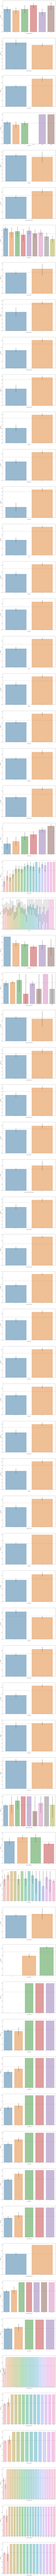

In [33]:
explore.make_bars(df, 'reassault', features1)

# For padding the data to make it balanced, double the non-reassault cases.

In [34]:
# isolate single abuse cases into 
single_abuse = df[df.reassault == 0]

In [35]:
# create new dataframe of just single abuse cases, reassign them new range of case ids
single_abuse['id'] = range(999999, 999999 + len(single_abuse))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
#append the padded single assault values to our greater dataframe
df = df.append(single_abuse)

In [37]:
# formally check that there are no nulls in dataframe
prepare.get_nulls_by_column(df)

Empty DataFrame
Columns: [sum_nulls, nulls_by_percent]
Index: []


In [38]:
# check no 2
if not prepare.get_nulls_by_row(df):
    print('no nulls!')
else:
    prepare.get_nulls_by_row(df)

no nulls!


In [39]:
df.shape

(644, 73)

In [40]:
df.reassault.value_counts()

1    350
0    294
Name: reassault, dtype: int64

# Make sure to drop the target variables

In [41]:
# create list of features
features = [col for col in df]
# drop features from this list that are perceived as primary key or target variable
features.remove('id')
features.remove('abuse_past_year')
features.remove('abuse_status')
features.remove('reassault')

In [42]:
len(features)

69

In [43]:
features

['length_relationship',
 'partner_abusive',
 'num_abusers',
 'num_children',
 'pregnant',
 'beaten_while_pregnant',
 'support_score',
 'guns_in_home',
 'jealous_past_year',
 'limit_family_contact',
 'location_tracking',
 'threat_hit',
 'threat_object',
 'push_shove',
 'slap',
 'kick_punch',
 'hit_object',
 'beaten',
 'choked',
 'threat_knife',
 'threat_gun',
 'rape_with_threat',
 'power_scale',
 'harass_scale',
 'id_age',
 'age_disparity',
 'children_not_partner',
 'same_sex_relationship',
 'partner_drug_use',
 'partner_alcohol_use',
 'threat_suicide',
 'partner_reported_child_abuse',
 'partner_arrested',
 'violence_increased',
 'severity_increased',
 'weapon_ever',
 'choked_ever',
 'rape_ever',
 'controlled_ever',
 'jealous',
 'capable_murder',
 'gun_fired',
 'anyone_high',
 'safe_place',
 'forced_illegal',
 'life_danger',
 'talk_about_it',
 'left_or_not',
 'medical_staff_helpful',
 'perp_arrested_ever',
 'police_resp',
 'order_protection',
 'level_severity',
 'num_incidents',
 'num_t

# Train/Test Split

In [44]:
# split train and test
X = df[features]
y = df[['reassault']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state = 0, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# EXPLORATION

## We will run chi-squared tests on our categorical variables in order to get a grasp of importance

In [45]:
# we will run chi-squared tests on our categorical variables in order to get a grasp of importance
sig_feats, sig_dict = explore.get_chi_squared(train_df, features, 'reassault')

length_relationship
Dependent (reject H0)
-----------------------
num_abusers
Dependent (reject H0)
-----------------------
beaten_while_pregnant
Dependent (reject H0)
-----------------------
support_score
Dependent (reject H0)
-----------------------
jealous_past_year
Dependent (reject H0)
-----------------------
limit_family_contact
Dependent (reject H0)
-----------------------
location_tracking
Dependent (reject H0)
-----------------------
threat_hit
Dependent (reject H0)
-----------------------
threat_object
Dependent (reject H0)
-----------------------
push_shove
Dependent (reject H0)
-----------------------
slap
Dependent (reject H0)
-----------------------
kick_punch
Dependent (reject H0)
-----------------------
hit_object
Dependent (reject H0)
-----------------------
beaten
Dependent (reject H0)
-----------------------
choked
Dependent (reject H0)
-----------------------
threat_knife
Dependent (reject H0)
-----------------------
threat_gun
Dependent (reject H0)
----------------

In [46]:
# scale continuous variables
scaler = MinMaxScaler()

scaler.fit(train_df[['id_age']])

train_df[['id_age']] = scaler.transform(train_df[['id_age']])
test_df[['id_age']] = scaler.transform(test_df[['id_age']])

In [47]:
continuous_vars = ['id_age']

In [48]:
sig_feats_c, sig_dict_c = explore.get_significant_t_tests(train_df, ['id_age'], 'reassault')

In [49]:
# call function that combines significant features from dictionaries created in statistical tests if both generated results
# otherwise make list of features just from whichever (t test or chi squared) produced significant results
if sig_feats_c and sig_feats:
    features = explore.combine_significants(sig_dict, sig_dict_c)
elif sig_feats_c:
    features = [item[0] for item in explore.sort_sigs(sig_dict_c)]
elif sig_feats:
    features = [item[0] for item in explore.sort_sigs(sig_dict)]

In [50]:
train_df.head()

,length_relationship,partner_abusive,num_abusers,num_children,pregnant,beaten_while_pregnant,support_score,guns_in_home,jealous_past_year,limit_family_contact,...,miscarriage_resulted,restrained_by_perp,num_choked,num_perp_drunk,num_woman_drunk,num_both_drunk,num_perp_drugs,num_woman_drugs,num_both_drugs,reassault
243,1,1,1,0,0,0,11,0,1,1,...,0,0,0,1,1,1,2,2,2,1
124,4,0,2,0,0,1,10,0,1,1,...,0,0,0,0,0,0,2,2,2,1
299,1,1,1,2,0,0,12,0,1,0,...,0,0,0,0,0,0,0,0,0,0
76,3,1,1,1,0,0,12,0,1,0,...,0,0,0,0,0,0,0,0,0,1
448,5,1,1,1,0,0,6,0,1,1,...,0,0,1,10,0,0,0,0,0,1


In [51]:
len(list(train_df.columns))

70

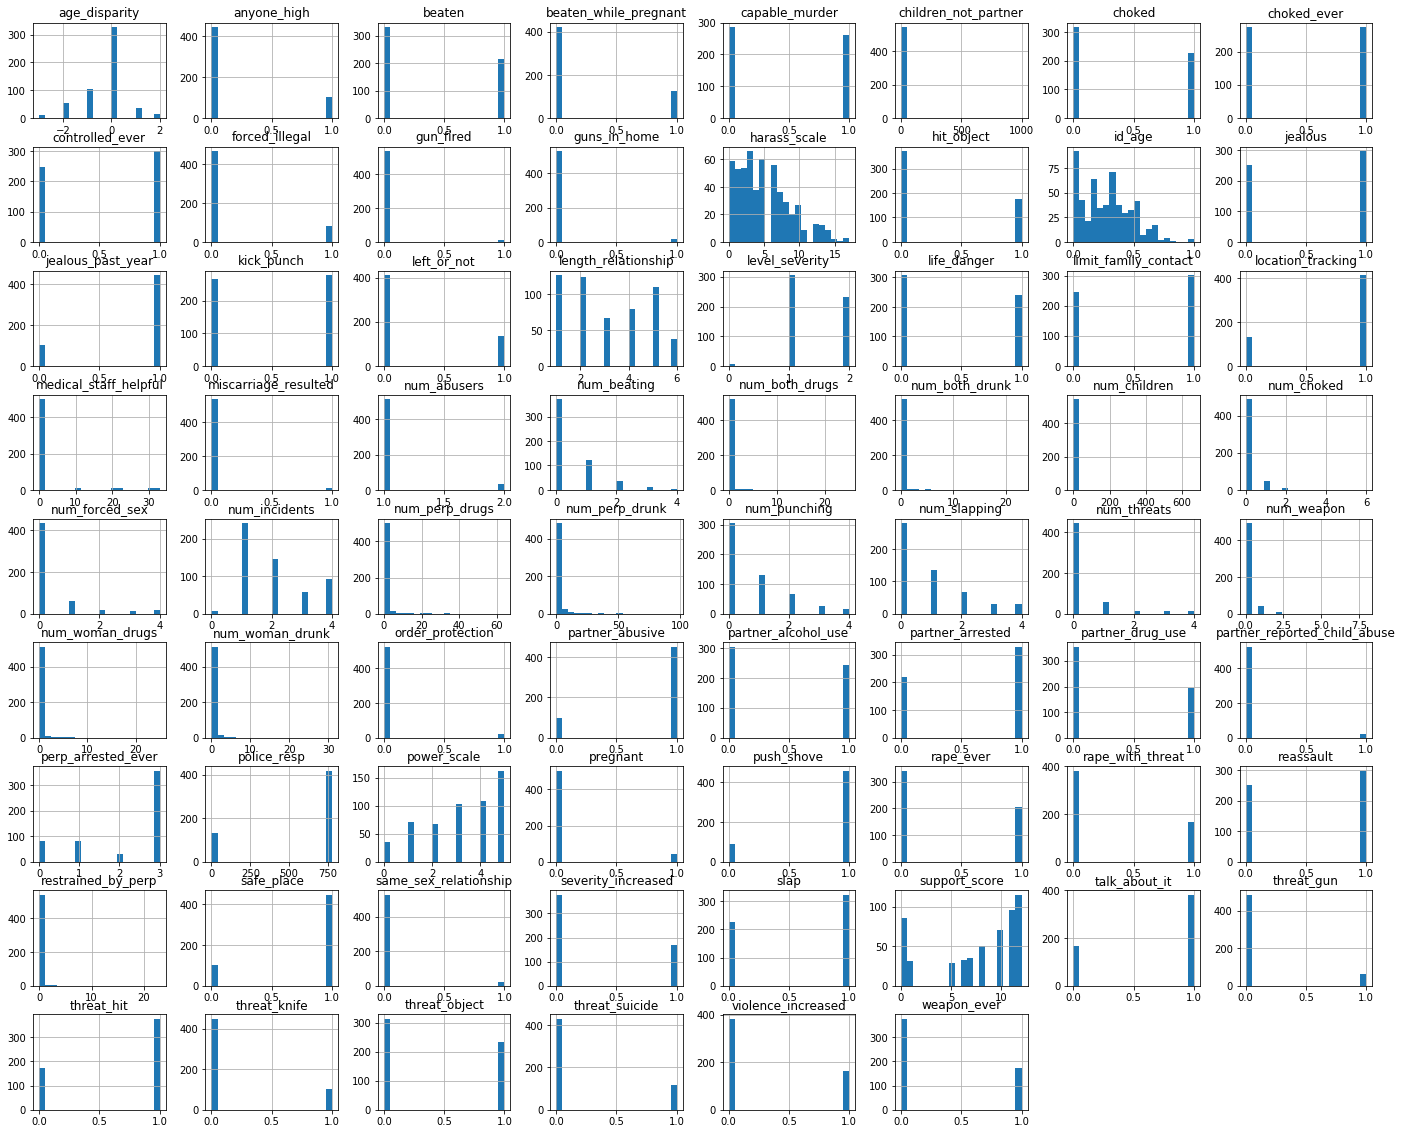

In [52]:
explore.plot_hist(train_df)

# After the significance testing, the length of the features list goes down to 58 features from 69. This list of features does not include left_or_not feature

In [53]:
len(features)

56

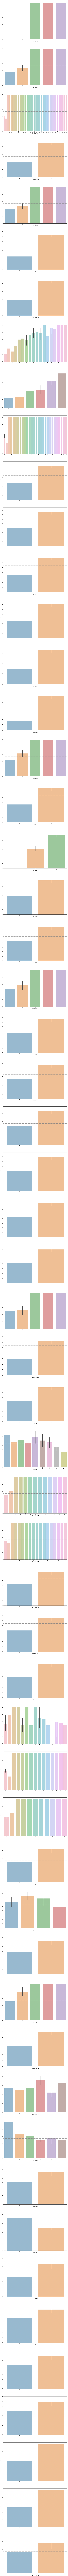

In [54]:
explore.make_bars(train_df, 'reassault', features)

# TSNE PLOT

# t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [55]:
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 0
time_start = time.time()

fashion_tsne = TSNE(n_components=2, init='random', verbose=1, perplexity=40, n_iter=450,  random_state=0)
tsne_results = fashion_tsne.fit_transform(train_df)

print(('t-SNE done! Time elapsed: {} seconds').format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 547 samples in 0.008s...
[t-SNE] Computed neighbors for 547 samples in 0.092s...
[t-SNE] Computed conditional probabilities for sample 547 / 547
[t-SNE] Mean sigma: 3.442531
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.767300
[t-SNE] Error after 450 iterations: 0.473657
t-SNE done! Time elapsed: 7.244755983352661 seconds


In [56]:
# Label to color dict (manual)
label_color_dict = {1:'Reassault',0:'Not reassault'}

# Color vector creation
cvec = [label_color_dict[label] for label in y_train.reassault]

# Plot t-sne

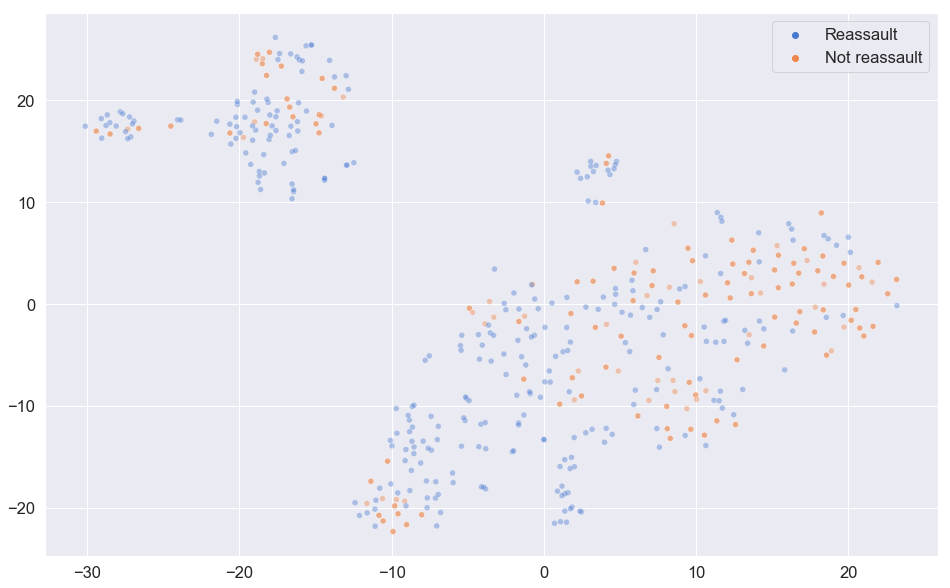

In [57]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=cvec,
    data=train_df,
    legend="full",
    alpha=0.4
)

# This is the (Principal Component Analysis) PCA.

In [58]:
pca = PCA(n_components=3, random_state=0)
pca_result = pca.fit_transform(train_df.values)
pca_df = pd.DataFrame()
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1] 
pca_df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [9.54175473e-01 4.35800854e-02 9.03896123e-04]


In [59]:
pca_df

,pca-one,pca-two,pca-three
0,-185.078303,-6.513650,-1.552105
1,591.888790,-0.472257,-3.370002
2,-185.091485,-6.300614,-3.848758
3,-185.117227,-3.408312,-3.756700
4,-185.069282,-6.884945,6.918111
5,-185.087347,-6.505976,1.624564
6,591.881343,3.013236,47.721700
7,581.878801,-0.529985,-4.562735
8,591.998598,-0.596609,41.033957
9,-185.076136,-6.532294,-2.215111


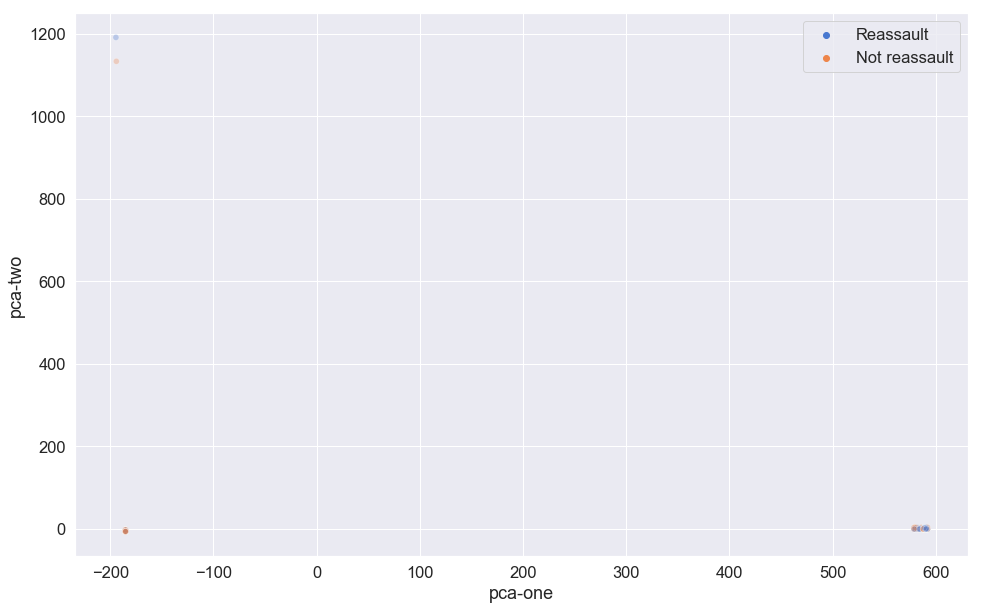

In [60]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_df['pca-one'], y=pca_df['pca-two'],
    hue=cvec,
    data=train_df,
    legend="full",
    alpha=0.3
)

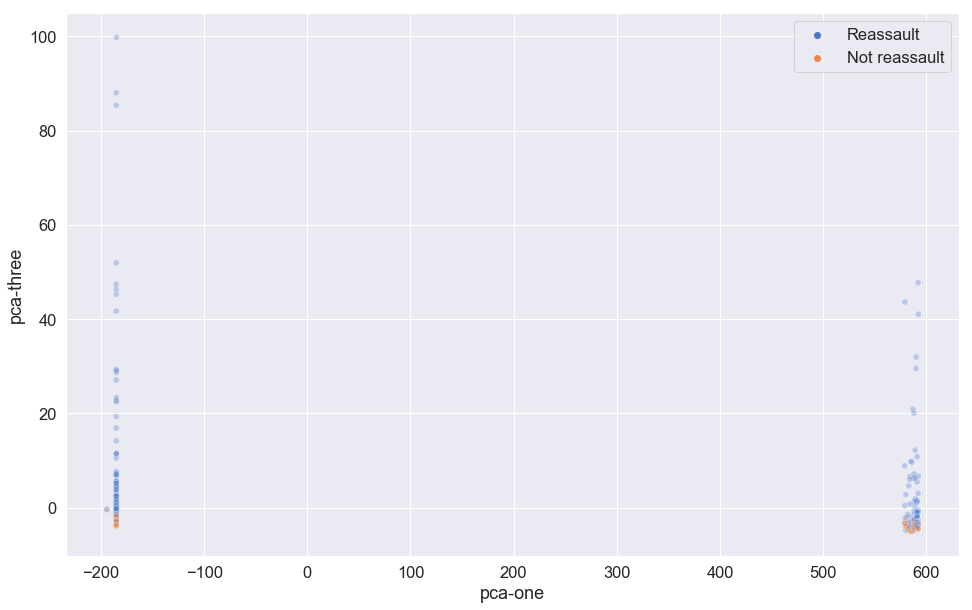

In [61]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_df['pca-one'], y=pca_df['pca-three'],
    hue=cvec,
    data=train_df,
    legend="full",
    alpha=0.3
)

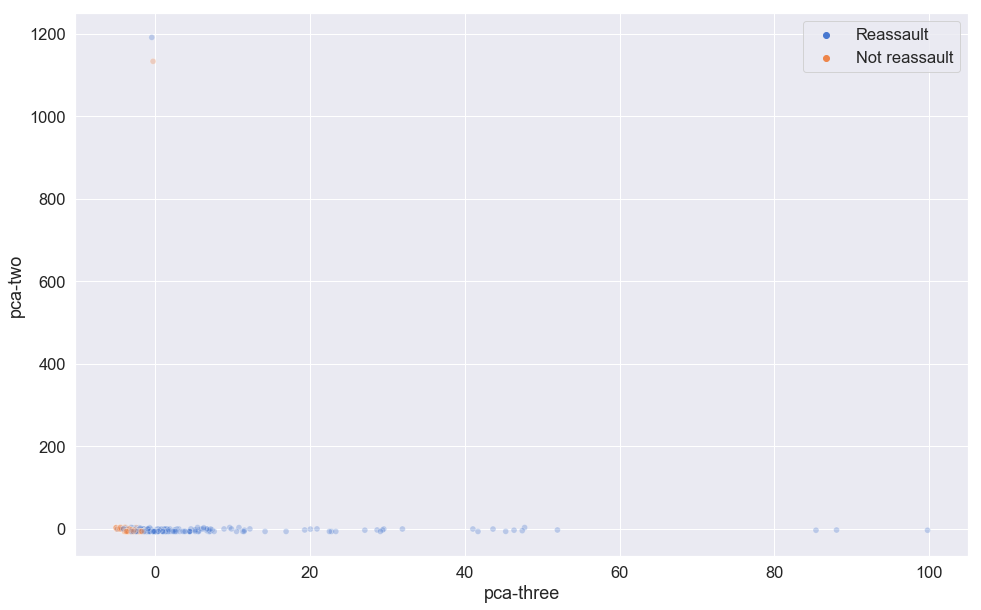

In [62]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_df['pca-three'], y=pca_df['pca-two'],
    hue=cvec,
    data=train_df,
    legend="full",
    alpha=0.3
)

# Bokeh Plots
### See for more information: https://programminghistorian.org/en/lessons/visualizing-with-bokeh#what-is-bokeh

### Do another train/test split using the first list of features which has 70 features, including the left_or_not

In [63]:
# split train and test
X = df[features1]
y = df[['reassault']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state = 0, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [64]:
import pandas as pd
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool

from bokeh.palettes import Spectral5
from bokeh.transform import factor_cmap

In [65]:
train_df.head()

,length_relationship,partner_abusive,num_abusers,num_children,pregnant,beaten_while_pregnant,support_score,guns_in_home,jealous_past_year,limit_family_contact,...,miscarriage_resulted,restrained_by_perp,num_choked,num_perp_drunk,num_woman_drunk,num_both_drunk,num_perp_drugs,num_woman_drugs,num_both_drugs,reassault
243,1,1,1,0,0,0,11,0,1,1,...,0,0,0,1,1,1,2,2,2,1
124,4,0,2,0,0,1,10,0,1,1,...,0,0,0,0,0,0,2,2,2,1
299,1,1,1,2,0,0,12,0,1,0,...,0,0,0,0,0,0,0,0,0,0
76,3,1,1,1,0,0,12,0,1,0,...,0,0,0,0,0,0,0,0,0,1
448,5,1,1,1,0,0,6,0,1,1,...,0,0,1,10,0,0,0,0,0,1


In [66]:
grouped = train_df.groupby('left_or_not')['rape_ever', 'reassault'].mean()
grouped

,rape_ever,reassault
left_or_not,,
0,0.362530,0.554745
1,0.426471,0.507353


In [67]:
grouped.rename(index = {0: "not_left", 
                     1:"left"}, inplace = True) 

In [68]:
grouped

,rape_ever,reassault
left_or_not,,
not_left,0.362530,0.554745
left,0.426471,0.507353


In [69]:
# Colored bar chart
output_file('leftornot_rape_reassault.html')

# establish the categories to plot
source = ColumnDataSource(grouped)

In [70]:
abuse_stat = list(np.unique(source.data['left_or_not']))
p = figure(x_range=abuse_stat)

In [71]:
abuse_stat

['left', 'not_left']

In [72]:
color_map = factor_cmap(field_name='left_or_not',
                    palette=Spectral5, factors=abuse_stat)
p.vbar(x='left_or_not', top='rape_ever', source=source, width=0.70, color=color_map)
p.title.text ='Rape and Reassault Based on Left/Leaving or Not Left/Leaving'
p.xaxis.axis_label = 'Left or Not'
p.yaxis.axis_label = 'Rape'

# adds the hover tool
hover = HoverTool()
hover.tooltips = [
    ("Averages", "@reassault Reassault")]

hover.mode = 'vline'

p.add_tools(hover)

show(p)

In [73]:
output_notebook()

Loading BokehJS ...

# Feature Engineer a column that categorically shows what type of violence occured, if any.

In [74]:
df.shape

(644, 73)

In [75]:
df_type_abuse = df.copy()

In [76]:
df_type_abuse.shape

(644, 73)

In [77]:
df_type_abuse.columns

Index(['id', 'abuse_past_year', 'abuse_status', 'length_relationship',
       'partner_abusive', 'num_abusers', 'num_children', 'pregnant',
       'beaten_while_pregnant', 'support_score', 'guns_in_home',
       'jealous_past_year', 'limit_family_contact', 'location_tracking',
       'threat_hit', 'threat_object', 'push_shove', 'slap', 'kick_punch',
       'hit_object', 'beaten', 'choked', 'threat_knife', 'threat_gun',
       'rape_with_threat', 'power_scale', 'harass_scale', 'id_age',
       'age_disparity', 'children_not_partner', 'same_sex_relationship',
       'partner_drug_use', 'partner_alcohol_use', 'threat_suicide',
       'partner_reported_child_abuse', 'partner_arrested',
       'violence_increased', 'severity_increased', 'weapon_ever',
       'choked_ever', 'rape_ever', 'controlled_ever', 'jealous',
       'capable_murder', 'gun_fired', 'anyone_high', 'safe_place',
       'forced_illegal', 'life_danger', 'talk_about_it', 'left_or_not',
       'medical_staff_helpful', 'perp_a

In [78]:
df_type_abuse.num_incidents.value_counts()

1    286
2    167
4    109
3     74
0      8
Name: num_incidents, dtype: int64

In [79]:
# creates a new column that returns a categorical label based off of boolean values in other features.
def label_type_abuse(df):
    if df['beaten_while_pregnant'] == 1:
        return 'beaten or beaten while pregnant'
    elif df['hit_object'] == 1:
        return 'hit with object'
    elif df['push_shove'] == 1:
        return 'push or shove'
    elif df['slap'] == 1:
        return 'slap'
    elif df['kick_punch'] == 1:
        return 'kick or punch'
    elif df['choked']:
        return 'choked'
    elif df['rape_ever']:
        return 'rape'
    elif df['restrained_by_perp'] != 999 or 0:
        return 'restrained'
    elif df['abuse_past_year'] == 0:
        return 'none'
    


In [80]:
df_type_abuse['type_abuse'] = df_type_abuse.apply(label_type_abuse, axis=1)

In [81]:
df_type_abuse.type_abuse.unique()

array(['push or shove', 'hit with object',
       'beaten or beaten while pregnant', 'restrained', 'slap',
       'kick or punch', 'rape', 'choked'], dtype=object)

In [82]:
# Jitter plot
# Import the necessary modules
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.io import show, output_file
from bokeh.transform import jitter
from bokeh.models import Range1d

# Construct the interactive tools
TOOLS = "crosshair,pan,wheel_zoom,box_zoom,reset,box_select,lasso_select"

# Format the data for the bokeh plot to use
source2 = ColumnDataSource(df_type_abuse)

# establish a y value for the not abused and then a y value for the abused
types_violence = ['push or shove', 'hit with object',
       'beaten or beaten while pregnant', 'restrained', 'slap',
       'kick or punch', 'rape', 'none', 'choked']

# Construct the figure
p = figure(plot_width=800, plot_height=300, y_range = types_violence, x_axis_type='linear', 
           title="Types of Violence with Abused Women")
p.x_range = Range1d(0,4)

# Plot the scatter plot in a jitterplot style
p.circle(x=jitter('num_incidents', width=0.6, range=p.x_range), y=jitter('type_abuse', width=1.6, range=p.y_range), size='power_scale', source=source2, alpha=0.3)

# Plot the power scale line
# p.line(x='num_incidents', y='harass_scale', line_width=1, source=source2)


# Create axis titles
p.xaxis.axis_label = 'Number of Incidents'
p.yaxis.axis_label = 'Types of violence'


# show the results
show(p)

# Output the file 
output_file('typesofabuse_jitterplot.html')

# PREPARATION

In [83]:
# function to remove any "significant features" that automatically denote target
prepare.remove_phase_2_features(features)

In [84]:
# create some subsets of significant features to assess model performance
top_5 = features[0:5]
top_10 = features[0:10]
top_15 = features[0:15]

# MODELING

# Import some more datasets... df9, df10, df13-15.

In [99]:
# df9 & 10 are cases of AW (Abused Woman)
df9 = acquire.read_data('data09.csv')
df10 = acquire.read_data('data10.csv')
df11 = acquire.read_data('data11.csv')
# df 13, 14 & 15 are cases of HOMICIDE
df13 = acquire.read_data('data13.csv')
df14 = acquire.read_data('data14.csv')
df15 = acquire.read_data('data15.csv')

In [100]:
df10.head()

,CASEID,INVIEWN,IDINCID,INCIDENT,FORCED,YEAR,MONTH,DAY,DATECERT,USOBJ,...,NDRUGS,BOTHDRUG,SUBSTANC,SEVEREST,TOINC,INTYEAR,INTMONTH,INTDAY,DAYSTOIN,DATECOM
0,108395,1,108395000,2,0,1997,12,15,2,2,...,0,0,1,2,1,1998,1,27,43,1
1,108397,1,108397000,1,0,1997,6,28,2,2,...,0,0,2,4,2,1998,1,27,213,1
2,108397,1,108397000,4,0,1998,1,20,2,1,...,0,0,2,4,999,1998,1,27,7,1
3,108399,1,108399000,1,0,1998,1,3,2,2,...,0,0,1,3,2,1998,1,30,27,1
4,108399,1,108399000,3,0,1998,1,27,2,2,...,0,0,1,3,999,1998,1,30,3,1


In [101]:
df11.head()

,CASEID,SEVEREST,SEVERER,TOTINC,TOTINCR,RECENT,RECENTR,RECENTRR,THREATS,THREATR,...,MISCARR,RESTRAIN,CHOKED,CHILD,NDRUNK,RDRUNK,BOTHDRUN,NDRUGS,RDRUGS,BOTHDRUG
0,108395,2,1,1,1,43,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108397,4,2,2,2,7,2,0,0,0,...,0,0,1,0,2,0,0,0,0,0
2,108399,3,2,2,2,3,1,0,0,0,...,0,1,1,0,0,0,0,0,0,0
3,108443,3,2,1,1,251,5,1,0,0,...,0,0,1,0,1,0,0,0,0,0
4,108444,1,1,5,3,39,3,0,0,0,...,0,0,0,0,3,0,0,0,0,0


In [102]:
df11.columns

Index(['CASEID', 'SEVEREST', 'SEVERER', 'TOTINC', 'TOTINCR', 'RECENT',
       'RECENTR', 'RECENTRR', 'THREATS', 'THREATR', 'SLAPPING', 'SLAPR',
       'PUNCHING', 'PUNCHR', 'BEATING', 'BEATR', 'TWEAPON', 'UWEAPON',
       'FORCEDSX', 'FORCEDR', 'WEAPON', 'GUN', 'KNIFE', 'MISCARR', 'RESTRAIN',
       'CHOKED', 'CHILD', 'NDRUNK', 'RDRUNK', 'BOTHDRUN', 'NDRUGS', 'RDRUGS',
       'BOTHDRUG'],
      dtype='object')

In [103]:
df11.describe()

,CASEID,SEVEREST,SEVERER,TOTINC,TOTINCR,RECENT,RECENTR,RECENTRR,THREATS,THREATR,...,MISCARR,RESTRAIN,CHOKED,CHILD,NDRUNK,RDRUNK,BOTHDRUN,NDRUGS,RDRUGS,BOTHDRUG
count,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,...,497.000000,497.000000,497.000000,497.000000,497.000000,497.00000,497.000000,497.000000,497.000000,497.000000
mean,387964.422535,2.559356,1.543260,18.048290,10.323944,99.901408,11.088531,8.255533,10.340040,8.498994,...,8.064386,8.261569,32.092555,10.414487,12.044266,8.60161,8.456740,10.219316,8.764588,8.525151
std,197319.742270,1.564796,0.836805,90.768192,89.152063,132.434023,89.090636,89.332635,89.917206,89.315816,...,89.349057,89.341769,96.890920,89.864825,89.940740,89.33316,89.334517,89.678223,89.351827,89.342535
min,108395.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,308037.000000,1.000000,1.000000,1.000000,1.000000,7.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,308498.000000,2.000000,1.000000,3.000000,2.000000,45.000000,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,508541.000000,4.000000,2.000000,9.000000,3.000000,162.000000,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,6.000000,0.000000,2.000000,0.00000,0.000000,1.000000,0.000000,0.000000
max,908003.000000,9.000000,9.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,...,999.000000,999.000000,999.000000,999.000000,999.000000,999.00000,999.000000,999.000000,999.000000,999.000000
